# PINNs 中的放大梯度流
首先定义一个模型 model, 并打印模型

In [1]:
import torch
import torch.nn as nn
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from math import pi
import numpy as np
import sobol_seq as sobol


class Unit(nn.Module):

    def __init__(self, in_N, out_N):
        super(Unit, self).__init__()
        self.in_N = in_N
        self.out_N = out_N
        self.L = nn.Linear(in_N, out_N)

    def forward(self, x):
        x1 = self.L(x)
        x2 = torch.tanh(x1)
        return x2


class NN(nn.Module):

    def __init__(self, in_N, width, depth, out_N):
        super(NN, self).__init__()
        self.width = width
        self.in_N = in_N
        self.out_N = out_N
        self.stack = nn.ModuleList()

        self.stack.append(Unit(in_N, width))

        for i in range(depth):
            self.stack.append(Unit(width, width))

        self.stack.append(nn.Linear(width, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x


def get_interior_points(N=128):
    """
    randomly sample N points from interior of [-1,1]^d
    """
    x1 = sobol.i4_sobol_generate(2, N) - np.array([1, 1])
    x2 = sobol.i4_sobol_generate(2, N) - np.array([1, 0])
    x3 = sobol.i4_sobol_generate(2, N) - np.array([0, 1])
    return torch.from_numpy(np.concatenate((x1, x2, x3), 0)).float()


def get_boundary_points(N=33):
    index = sobol.i4_sobol_generate(1, N)
    index1 = sobol.i4_sobol_generate(1, N) * 2 - 1
    xb1 = np.concatenate((index, np.zeros_like(index)), 1)
    xb2 = np.concatenate((index1, - np.ones_like(index1)), 1)
    xb3 = np.concatenate((index - 1, np.ones_like(index)), 1)
    xb4 = np.concatenate((np.zeros_like(index), index), 1)
    xb5 = np.concatenate((np.full_like(index1, -1), index1), 1)
    xb6 = np.concatenate((np.ones_like(index), index - 1), 1)
    xb = torch.from_numpy(np.concatenate((xb1, xb2, xb3, xb4, xb5, xb6), 0)).float()

    return xb

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)

in_N = 2
width = 50
depth = 1
out_N = 1

print(torch.cuda.is_available())
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model = NN(in_N, width, depth, out_N).to(device)
model.apply(weights_init)

optimizer = optim.Adam(model.parameters(), lr=1e-2)
print(model)

False
NN(
  (stack): ModuleList(
    (0): Unit(
      (L): Linear(in_features=2, out_features=50, bias=True)
    )
    (1): Unit(
      (L): Linear(in_features=50, out_features=50, bias=True)
    )
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


打印参数的名称

In [2]:
#  打印参数的名称
for name in model.state_dict():
    print(name)

stack.0.L.weight
stack.0.L.bias
stack.1.L.weight
stack.1.L.bias
stack.2.weight
stack.2.bias


知道参数的名称之后， 我们可以查看参数的值， 比如说 stack.0.L.weight 和 stack.2.L.bias

In [3]:
print('Parameters_0_weight', model.state_dict()['stack.0.L.weight'].shape, model.state_dict()['stack.0.L.weight'], '\n')
print('Parameters_2_bias', model.state_dict()['stack.1.L.bias'].shape, model.state_dict()['stack.1.L.bias'])

Parameters_0_weight torch.Size([50, 2]) tensor([[ 0.3242,  0.1362],
        [ 0.0621, -0.1595],
        [ 0.5444,  0.0908],
        [-0.2832, -0.0061],
        [ 0.1256,  0.1044],
        [ 0.3340, -0.1641],
        [-0.2347,  0.0091],
        [-0.1463,  0.3074],
        [-0.1613, -0.2171],
        [ 0.0623, -0.2989],
        [-0.0197,  0.1269],
        [-0.0882, -0.1299],
        [-0.2423,  0.0484],
        [ 0.0322, -0.1355],
        [-0.1674, -0.0807],
        [-0.3725,  0.3309],
        [-0.1412,  0.0302],
        [ 0.1020, -0.0544],
        [-0.5955,  0.1617],
        [ 0.3890,  0.0145],
        [-0.2850,  0.0473],
        [ 0.1478, -0.3460],
        [ 0.1862,  0.2237],
        [-0.3195,  0.4232],
        [-0.2312,  0.1160],
        [ 0.1342,  0.0178],
        [-0.0362, -0.1058],
        [-0.1042,  0.0161],
        [ 0.0119, -0.0272],
        [ 0.2055,  0.0248],
        [-0.1782, -0.4173],
        [ 0.0875,  0.0861],
        [-0.2763,  0.0668],
        [ 0.0085,  0.1249],
        

In [4]:
params = list(model.named_parameters())#get the index by debuging
print(params[0][0])
print(params[1][0])
print(params[2][0])#name
print(params[2][1].data)#data
print(params[2][1].grad)

stack.0.L.weight
stack.0.L.bias
stack.1.L.weight
tensor([[-0.0007,  0.4530, -0.1119,  ...,  0.0010,  0.1064, -0.2347],
        [-0.1895,  0.1312,  0.0693,  ...,  0.0707,  0.0059,  0.1439],
        [-0.0755,  0.0045, -0.1132,  ..., -0.1292,  0.0766,  0.0142],
        ...,
        [ 0.1152,  0.1007, -0.1369,  ...,  0.0612, -0.0630, -0.1888],
        [-0.0135, -0.0340, -0.3551,  ..., -0.1462, -0.0594,  0.1513],
        [ 0.0013, -0.0048,  0.1175,  ...,  0.0255, -0.1313,  0.0527]])
None


为了显示损失函数对参数的导数， 我们考虑如下PDE:
$$-\Delta u = 0 \;in\; \Omega \\
u = r^{1/2}sin(\theta/2)\; on\; \Gamma$$
其中 $\Omega = (-1, 1)^2 \backslash (0,1)^2$, exact solution: $u = r^{1/2}sin(\theta/2).$

lamb tensor([900.0129]) r: tensor(0.1909) b tensor(0.0247) tensor(0.1292)
lr 0.01
0.05987191200256348 epoch: 0 loss: 563.5213012695312 loss_r: 0.002742962446063757 loss_b: 563.5185546875
lamb tensor([810.0124]) r: tensor(5.1093) b tensor(0.0413) tensor(0.0081)
lr 0.01
lamb tensor([729.0128]) r: tensor(10.7716) b tensor(0.1844) tensor(0.0171)
lr 0.01
lamb tensor([656.1146]) r: tensor(4.2641) b tensor(0.1326) tensor(0.0311)
lr 0.01
lamb tensor([590.5038]) r: tensor(10.3811) b tensor(0.0694) tensor(0.0067)
lr 0.01
lamb tensor([531.4545]) r: tensor(7.8429) b tensor(0.0800) tensor(0.0102)
lr 0.01
lamb tensor([478.3112]) r: tensor(5.4373) b tensor(0.1188) tensor(0.0218)
lr 0.01
lamb tensor([430.4825]) r: tensor(5.3369) b tensor(0.1320) tensor(0.0247)
lr 0.01
lamb tensor([387.4370]) r: tensor(4.7380) b tensor(0.1271) tensor(0.0268)
lr 0.01
lamb tensor([348.6971]) r: tensor(2.8319) b tensor(0.1105) tensor(0.0390)
lr 0.01
lamb tensor([313.8307]) r: tensor(2.8199) b tensor(0.0936) tensor(0.0332)

lamb tensor([18.5032]) r: tensor(0.0058) b tensor(0.1172) tensor(20.1872)
lr 0.01
lamb tensor([18.8853]) r: tensor(0.0052) b tensor(0.1170) tensor(22.3246)
lr 0.01
lamb tensor([19.3085]) r: tensor(0.0050) b tensor(0.1167) tensor(23.1169)
lr 0.01
lamb tensor([19.2250]) r: tensor(0.0063) b tensor(0.1164) tensor(18.4732)
lr 0.01
lamb tensor([18.0688]) r: tensor(0.0152) b tensor(0.1162) tensor(7.6629)
lr 0.01
lamb tensor([17.5120]) r: tensor(0.0093) b tensor(0.1161) tensor(12.5015)
lr 0.01
lamb tensor([17.8445]) r: tensor(0.0056) b tensor(0.1161) tensor(20.8372)
lr 0.01
lamb tensor([18.2379]) r: tensor(0.0053) b tensor(0.1160) tensor(21.7783)
lr 0.01
lamb tensor([18.5376]) r: tensor(0.0055) b tensor(0.1160) tensor(21.2344)
lr 0.01
lamb tensor([18.7387]) r: tensor(0.0056) b tensor(0.1159) tensor(20.5493)
lr 0.01
lamb tensor([18.9633]) r: tensor(0.0055) b tensor(0.1159) tensor(20.9842)
lr 0.01
lamb tensor([19.1995]) r: tensor(0.0054) b tensor(0.1158) tensor(21.3255)
lr 0.01
lamb tensor([19.2

lamb tensor([22.3878]) r: tensor(0.0054) b tensor(0.1218) tensor(22.6276)
lr 0.01
lamb tensor([22.4125]) r: tensor(0.0054) b tensor(0.1220) tensor(22.6348)
lr 0.01
lamb tensor([22.3508]) r: tensor(0.0056) b tensor(0.1221) tensor(21.7955)
lr 0.01
lamb tensor([22.1672]) r: tensor(0.0060) b tensor(0.1222) tensor(20.5155)
lr 0.01
lamb tensor([22.1351]) r: tensor(0.0056) b tensor(0.1224) tensor(21.8460)
lr 0.01
lamb tensor([22.2701]) r: tensor(0.0052) b tensor(0.1226) tensor(23.4845)
lr 0.01
lamb tensor([22.3811]) r: tensor(0.0052) b tensor(0.1227) tensor(23.3804)
lr 0.01
lamb tensor([22.4523]) r: tensor(0.0053) b tensor(0.1229) tensor(23.0935)
lr 0.01
lamb tensor([22.3634]) r: tensor(0.0057) b tensor(0.1230) tensor(21.5630)
lr 0.01
lamb tensor([22.2955]) r: tensor(0.0057) b tensor(0.1232) tensor(21.6846)
lr 0.01
lamb tensor([22.6137]) r: tensor(0.0048) b tensor(0.1234) tensor(25.4770)
lr 0.01
lamb tensor([22.8681]) r: tensor(0.0049) b tensor(0.1235) tensor(25.1580)
lr 0.01
lamb tensor([22.

lamb tensor([24.2559]) r: tensor(0.0060) b tensor(0.1401) tensor(23.5122)
lr 0.01
lamb tensor([24.3836]) r: tensor(0.0055) b tensor(0.1403) tensor(25.5330)
lr 0.01
lamb tensor([24.2713]) r: tensor(0.0060) b tensor(0.1405) tensor(23.2609)
lr 0.01
lamb tensor([24.3142]) r: tensor(0.0057) b tensor(0.1406) tensor(24.7004)
lr 0.01
lamb tensor([24.5956]) r: tensor(0.0052) b tensor(0.1408) tensor(27.1278)
lr 0.01
lamb tensor([24.5340]) r: tensor(0.0059) b tensor(0.1409) tensor(23.9799)
lr 0.01
lamb tensor([24.3398]) r: tensor(0.0062) b tensor(0.1410) tensor(22.5913)
lr 0.01
lamb tensor([24.2778]) r: tensor(0.0060) b tensor(0.1412) tensor(23.7205)
lr 0.01
lamb tensor([24.2259]) r: tensor(0.0059) b tensor(0.1413) tensor(23.7590)
lr 0.01
lamb tensor([24.1820]) r: tensor(0.0059) b tensor(0.1415) tensor(23.7869)
lr 0.01
lamb tensor([24.1444]) r: tensor(0.0059) b tensor(0.1416) tensor(23.8056)
lr 0.01
lamb tensor([24.2925]) r: tensor(0.0055) b tensor(0.1418) tensor(25.6251)
lr 0.01
lamb tensor([24.

lr 0.01
lamb tensor([19.8627]) r: tensor(0.0065) b tensor(0.1302) tensor(20.1359)
lr 0.01
lamb tensor([19.8659]) r: tensor(0.0065) b tensor(0.1296) tensor(19.8943)
lr 0.01
lamb tensor([19.7861]) r: tensor(0.0068) b tensor(0.1290) tensor(19.0676)
lr 0.01
lamb tensor([19.5150]) r: tensor(0.0075) b tensor(0.1284) tensor(17.0759)
lr 0.01
lamb tensor([19.2781]) r: tensor(0.0075) b tensor(0.1278) tensor(17.1458)
lr 0.01
lamb tensor([19.1938]) r: tensor(0.0069) b tensor(0.1273) tensor(18.4350)
lr 0.01
lamb tensor([19.2566]) r: tensor(0.0064) b tensor(0.1266) tensor(19.8222)
lr 0.01
lamb tensor([19.3457]) r: tensor(0.0063) b tensor(0.1260) tensor(20.1468)
lr 0.01
lamb tensor([19.3451]) r: tensor(0.0065) b tensor(0.1253) tensor(19.3400)
lr 0.01
lamb tensor([19.0439]) r: tensor(0.0076) b tensor(0.1246) tensor(16.3333)
lr 0.01
lamb tensor([18.7617]) r: tensor(0.0076) b tensor(0.1237) tensor(16.2218)
lr 0.01
lamb tensor([18.4387]) r: tensor(0.0079) b tensor(0.1229) tensor(15.5318)
lr 0.01
lamb ten

lamb tensor([11.2077]) r: tensor(0.0060) b tensor(0.0671) tensor(11.2089)
lr 0.01
lamb tensor([11.2190]) r: tensor(0.0060) b tensor(0.0677) tensor(11.3204)
lr 0.01
lamb tensor([11.4798]) r: tensor(0.0049) b tensor(0.0682) tensor(13.8270)
lr 0.01
lamb tensor([11.5980]) r: tensor(0.0054) b tensor(0.0688) tensor(12.6621)
lr 0.01
lamb tensor([11.9072]) r: tensor(0.0047) b tensor(0.0693) tensor(14.6896)
lr 0.01
lamb tensor([11.9708]) r: tensor(0.0056) b tensor(0.0699) tensor(12.5435)
lr 0.01
lamb tensor([12.1025]) r: tensor(0.0053) b tensor(0.0704) tensor(13.2874)
lr 0.01
lamb tensor([12.3120]) r: tensor(0.0050) b tensor(0.0710) tensor(14.1983)
lr 0.01
lamb tensor([12.3262]) r: tensor(0.0057) b tensor(0.0716) tensor(12.4537)
lr 0.01
lamb tensor([12.6101]) r: tensor(0.0048) b tensor(0.0722) tensor(15.1655)
lr 0.01
lamb tensor([12.6649]) r: tensor(0.0055) b tensor(0.0727) tensor(13.1582)
lr 0.01
lamb tensor([12.8327]) r: tensor(0.0051) b tensor(0.0733) tensor(14.3426)
lr 0.01
lamb tensor([12.

lr 0.01
lamb tensor([7.8322]) r: tensor(0.0079) b tensor(0.0762) tensor(9.6340)
lr 0.01
lamb tensor([7.4195]) r: tensor(0.0204) b tensor(0.0757) tensor(3.7050)
lr 0.01
lamb tensor([6.9823]) r: tensor(0.0248) b tensor(0.0757) tensor(3.0471)
lr 0.01
lamb tensor([7.6931]) r: tensor(0.0054) b tensor(0.0762) tensor(14.0904)
lr 0.01
lamb tensor([7.5586]) r: tensor(0.0121) b tensor(0.0767) tensor(6.3488)
lr 0.01
lamb tensor([7.3628]) r: tensor(0.0137) b tensor(0.0768) tensor(5.6003)
lr 0.01
lamb tensor([8.1958]) r: tensor(0.0049) b tensor(0.0765) tensor(15.6929)
lr 0.01
lamb tensor([7.6218]) r: tensor(0.0310) b tensor(0.0762) tensor(2.4561)
lr 0.01
lamb tensor([9.0209]) r: tensor(0.0035) b tensor(0.0766) tensor(21.6125)
lr 0.01
lamb tensor([9.1397]) r: tensor(0.0075) b tensor(0.0770) tensor(10.2088)
lr 0.01
lamb tensor([8.9796]) r: tensor(0.0103) b tensor(0.0773) tensor(7.5384)
lr 0.01
lamb tensor([9.8179]) r: tensor(0.0045) b tensor(0.0773) tensor(17.3631)
lr 0.01
lamb tensor([9.0509]) r: te

lamb tensor([8.1823]) r: tensor(0.0077) b tensor(0.0888) tensor(11.4762)
lr 0.01
lamb tensor([7.8467]) r: tensor(0.0184) b tensor(0.0887) tensor(4.8257)
lr 0.01
lamb tensor([7.8363]) r: tensor(0.0115) b tensor(0.0891) tensor(7.7429)
lr 0.01
lamb tensor([7.8627]) r: tensor(0.0110) b tensor(0.0891) tensor(8.1001)
lr 0.01
lamb tensor([7.5283]) r: tensor(0.0196) b tensor(0.0887) tensor(4.5187)
lr 0.01
lamb tensor([8.5113]) r: tensor(0.0051) b tensor(0.0888) tensor(17.3591)
lr 0.01
lamb tensor([9.0143]) r: tensor(0.0066) b tensor(0.0888) tensor(13.5413)
lr 0.01
lamb tensor([8.4558]) r: tensor(0.0258) b tensor(0.0886) tensor(3.4294)
lr 0.01
lamb tensor([8.2872]) r: tensor(0.0132) b tensor(0.0891) tensor(6.7691)
lr 0.01
lamb tensor([8.1139]) r: tensor(0.0136) b tensor(0.0892) tensor(6.5548)
lr 0.01
lamb tensor([7.9283]) r: tensor(0.0142) b tensor(0.0889) tensor(6.2576)
lr 0.01
lamb tensor([7.7548]) r: tensor(0.0144) b tensor(0.0889) tensor(6.1930)
lr 0.01
lamb tensor([7.7783]) r: tensor(0.011

lr 0.01
lamb tensor([8.3530]) r: tensor(0.0039) b tensor(0.0851) tensor(21.5532)
lr 0.01
lamb tensor([8.0206]) r: tensor(0.0169) b tensor(0.0849) tensor(5.0290)
lr 0.01
lamb tensor([7.4481]) r: tensor(0.0368) b tensor(0.0846) tensor(2.2960)
lr 0.01
lamb tensor([7.1159]) r: tensor(0.0207) b tensor(0.0852) tensor(4.1256)
lr 0.01
lamb tensor([6.8987]) r: tensor(0.0173) b tensor(0.0853) tensor(4.9443)
lr 0.01
lamb tensor([6.4886]) r: tensor(0.0303) b tensor(0.0848) tensor(2.7974)
lr 0.01
lamb tensor([6.3978]) r: tensor(0.0152) b tensor(0.0851) tensor(5.5809)
lr 0.01
lamb tensor([6.2183]) r: tensor(0.0186) b tensor(0.0856) tensor(4.6025)
lr 0.01
lamb tensor([6.3907]) r: tensor(0.0107) b tensor(0.0853) tensor(7.9426)
lr 0.01
lamb tensor([6.1426]) r: tensor(0.0217) b tensor(0.0849) tensor(3.9095)
lr 0.01
lamb tensor([5.8906]) r: tensor(0.0235) b tensor(0.0850) tensor(3.6226)
lr 0.01
lamb tensor([5.9960]) r: tensor(0.0122) b tensor(0.0850) tensor(6.9449)
lr 0.01
lamb tensor([6.0470]) r: tensor

lr 0.01
lamb tensor([6.9281]) r: tensor(0.0158) b tensor(0.0760) tensor(4.8040)
lr 0.01
lamb tensor([6.5021]) r: tensor(0.0284) b tensor(0.0757) tensor(2.6685)
lr 0.01
lamb tensor([6.0677]) r: tensor(0.0353) b tensor(0.0762) tensor(2.1575)
lr 0.01
lamb tensor([5.7165]) r: tensor(0.0297) b tensor(0.0759) tensor(2.5560)
lr 0.01
lamb tensor([5.7774]) r: tensor(0.0121) b tensor(0.0764) tensor(6.3253)
lr 0.01
lamb tensor([6.5345]) r: tensor(0.0057) b tensor(0.0764) tensor(13.3485)
lr 0.01
lamb tensor([6.2640]) r: tensor(0.0199) b tensor(0.0762) tensor(3.8300)
lr 0.01
lamb tensor([6.6281]) r: tensor(0.0077) b tensor(0.0766) tensor(9.9049)
lr 0.01
lamb tensor([6.9386]) r: tensor(0.0079) b tensor(0.0767) tensor(9.7327)
lr 0.01
lamb tensor([7.0835]) r: tensor(0.0091) b tensor(0.0766) tensor(8.3879)
lr 0.01
lamb tensor([7.0481]) r: tensor(0.0114) b tensor(0.0767) tensor(6.7297)
lr 0.01
lamb tensor([6.7357]) r: tensor(0.0195) b tensor(0.0764) tensor(3.9240)
lr 0.01
lamb tensor([6.5402]) r: tensor

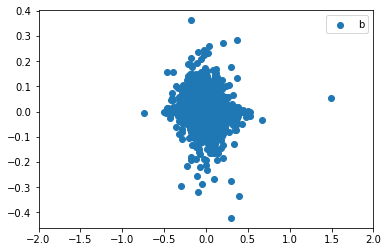

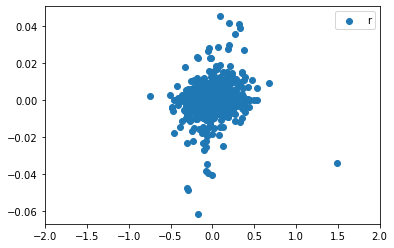

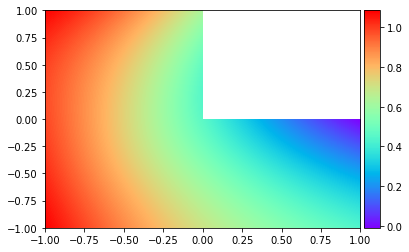

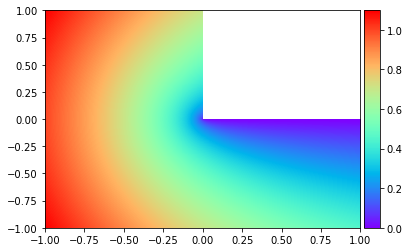

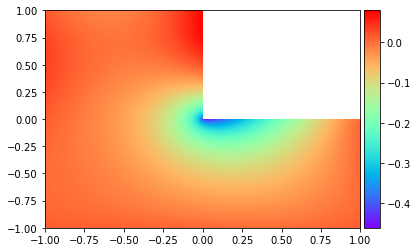

In [5]:
def function_u_exact(x):
    r = torch.sqrt(x[:, 0:1] ** 2 + x[:, 1: 2] ** 2)
    sin_theta_2 = torch.where(r==0, torch.zeros_like(r), torch.sqrt((1-x[:, 0:1] / r) / 2))
    return torch.sqrt(r) * sin_theta_2

def gradients(input, output):
    return autograd.grad(outputs=output, inputs=input,
                                grad_outputs=torch.ones_like(output),
                                create_graph=True, retain_graph=True, only_inputs=True)[0]

lr = []
StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
tt = time.time()
lamb = torch.tensor([1000.0])
xr = get_interior_points(1000)
xb = get_boundary_points(N=200)
epochs = 1000
xr = xr.to(device)
xb = xb.to(device)
for epoch in range(epochs+1):
    # generate the data set
    xr.requires_grad_()
    output_r = model(xr)
    output_b = model(xb)
    exact_b = function_u_exact(xb)
    grads = autograd.grad(outputs=output_r, inputs=xr,
                          grad_outputs=torch.ones_like(output_r),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    grads2 = gradients(xr, grads[:, 0: 1])[:, 0: 1] + gradients(xr, grads[:, 1: 2])[:, 1: 2]
    loss_r = torch.mean(torch.square(grads2))
    loss_b = lamb * torch.mean(torch.abs(output_b - exact_b))
    if epoch != epochs:
        loss = loss_r + loss_b
        optimizer.zero_grad()
        loss_b.backward(retain_graph=True)
        tmp1 = torch.mean(torch.abs(params[2][1].grad))
        optimizer.zero_grad()
        loss_r.backward(retain_graph=True)
        tmp2 = torch.max(torch.abs(params[2][1].grad))
        lamb_new = torch.abs(tmp2 / tmp1)
        lamb = lamb_new * 0.1 + 0.9 * lamb
        #lamb = lamb_new
        print('lamb', lamb, 'r:', tmp1, 'b', tmp2, lamb_new)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        StepLR.step()
        print('lr', optimizer.state_dict()['param_groups'][0]['lr'])
    if epoch % 100 == 0:
        print(time.time() - tt, 'epoch:', epoch, 'loss:', loss.item(), 'loss_r:', loss_r.item(), 'loss_b:', loss_b.item())
        tt = time.time()
    if epoch == epochs:
        optimizer.zero_grad()
        loss_b.backward(retain_graph=True)
        tmp_b = params[2][1].grad.reshape(-1, 1)
        plt.figure()
        tmp_x = params[2][1].data.reshape(-1, 1)
        plt.scatter(tmp_x, tmp_b, label='b')
        plt.xlim([-2, 2])
        plt.legend()

        print('max of tmp_b:', torch.max(tmp_b))
        print('max of tmp_x:', torch.abs(torch.max(tmp_x)))
        optimizer.zero_grad()
        loss_r.backward()
        tmp_r = params[2][1].grad.reshape(-1, 1)
        plt.figure()
 
        plt.scatter(tmp_x, tmp_r, label='r')
        plt.xlim([-2, 2])
        plt.legend()
with torch.no_grad():
    N0 = 1000
    x1 = np.linspace(-1, 0, N0 + 1)
    x2 = np.linspace(-1, 1, 2 * N0 + 1)
    x3 = np.linspace(0, 1, N0 + 1)

    xs1, ys1 = np.meshgrid(x1, x2)
    xs2, ys2 = np.meshgrid(x3, x1)
    Z1 = torch.from_numpy(np.concatenate((xs1.flatten()[:, None], ys1.flatten()[:, None]), 1)).float()
    Z2 = torch.from_numpy(np.concatenate((xs2.flatten()[:, None], ys2.flatten()[:, None]), 1)).float()
    pred1 = torch.reshape(model(Z1), [2 * N0 + 1, N0 + 1])
    pred2 = torch.reshape(model(Z2), [N0 + 1, N0 + 1])
    pred1 = pred1.cpu().numpy()
    pred2 = pred2.cpu().numpy()
    pred3 = pred2 * np.nan
    pred = np.concatenate((pred1, np.concatenate((pred2, pred3[1:, :]), 0)), 1)
    exact1 = torch.reshape(function_u_exact(Z1), [2 * N0 + 1, N0 + 1]).cpu().numpy()
    exact2 = torch.reshape(function_u_exact(Z2), [N0 + 1, N0 + 1]).cpu().numpy()
    exact = np.concatenate((exact1, np.concatenate((exact2, exact2[1:, :] * np.nan), 0)), 1)
    np.save('ex2_dgm_err.npy', np.abs(pred-exact))
err = np.sqrt((np.sum(np.square(exact1 - pred1)) + np.sum(np.square(exact2 - pred2))) / (np.sum(np.square(exact1)) + np.sum(np.square(exact2))))
print("Error:", err)

plt.figure()
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='rainbow',
               extent=[-1, 1, -1, 1],
               origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)

plt.figure()
ax2 = plt.subplot(1, 1, 1)
h1 = plt.imshow(exact, interpolation='nearest', cmap='rainbow',
                extent=[-1, 1, -1, 1],
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h1, cax=cax)

plt.figure()
ax3 = plt.subplot(1, 1, 1)
h2 = plt.imshow(exact-pred, interpolation='nearest', cmap='rainbow',
                extent=[-1, 1, -1, 1],
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h2, cax=cax)
plt.show()


接下来， 我们给出 Paris Perdikaris 文章 understanding ad mitigating gradient pathologies in physics-indormed neural networks 中的自适应罚因子算法。 算法的关键部分是计算损失函数对参数的导数(不是物理空间变量的导数)。 
我们先看看怎样 pytorch 实现对中间变量的求导， 再将其推广到 model 中。

In [6]:
for param in model.named_parameters():
    print(param[0])
    print(param[1])
    x = param[1].grad

stack.0.L.weight
Parameter containing:
tensor([[ 0.3855, -0.2325],
        [ 0.0448, -0.1544],
        [ 0.5569,  0.1212],
        [-0.2991, -0.0428],
        [ 0.1343,  0.0693],
        [ 0.2756, -0.1566],
        [-0.1527,  0.1365],
        [-0.1146,  0.3897],
        [-0.1958, -0.1269],
        [ 0.0318, -0.3523],
        [-0.0067,  0.0780],
        [-0.1147, -0.0786],
        [-0.1353, -0.0357],
        [ 0.0113, -0.0403],
        [-0.1173, -0.0974],
        [-0.3776,  0.2518],
        [-0.1228, -0.0132],
        [ 0.0949, -0.0853],
        [-0.6714,  0.2303],
        [ 0.3853,  0.0402],
        [-0.2409,  0.0014],
        [ 0.1100, -0.3718],
        [ 0.2318,  0.1059],
        [-0.3342,  0.3770],
        [-0.2799,  0.1315],
        [ 0.1618, -0.0060],
        [-0.0557, -0.1348],
        [-0.0941,  0.0154],
        [-0.0077, -0.0072],
        [ 0.1871,  0.0290],
        [-0.1985, -0.4072],
        [ 0.0622,  0.1019],
        [-0.2918,  0.0865],
        [ 0.0280,  0.1277],
        [

In [7]:
for name, parms in model.named_parameters():
    print('-->name:', name, '-->grad_requirs:',parms.requires_grad, ' -->grad_value:',parms.grad)

-->name: stack.0.L.weight -->grad_requirs: True  -->grad_value: tensor([[ 1.5971e-02, -4.9851e-02],
        [ 6.5247e-04, -6.3840e-03],
        [-3.2878e-03,  1.0945e-02],
        [ 8.8108e-03, -2.1574e-03],
        [ 9.2562e-04, -1.3938e-02],
        [ 9.3249e-03, -2.5478e-02],
        [ 1.1846e-03,  1.8097e-02],
        [-2.1047e-02,  4.0407e-02],
        [-6.8306e-03,  2.2999e-02],
        [ 5.9028e-03, -3.4707e-03],
        [ 3.1440e-04, -2.1676e-03],
        [ 1.3397e-03, -6.6179e-03],
        [ 3.8256e-03,  1.1358e-02],
        [ 8.4741e-03, -3.8411e-04],
        [ 1.2682e-02,  2.6587e-03],
        [-3.3613e-03,  7.0144e-03],
        [ 1.3040e-02, -1.5044e-02],
        [ 1.4558e-02, -3.7879e-02],
        [-2.9441e-02,  4.9106e-02],
        [ 1.3525e-02,  8.5484e-03],
        [-3.4695e-03,  9.9789e-03],
        [ 2.3349e-02, -4.7917e-02],
        [ 4.3678e-03,  2.0385e-02],
        [-3.4497e-02,  5.1061e-02],
        [-6.6521e-04,  2.5859e-02],
        [ 6.0317e-03, -2.3447e-02],


In [8]:
model.state_dict()['stack.0.L.weight']

tensor([[ 0.3855, -0.2325],
        [ 0.0448, -0.1544],
        [ 0.5569,  0.1212],
        [-0.2991, -0.0428],
        [ 0.1343,  0.0693],
        [ 0.2756, -0.1566],
        [-0.1527,  0.1365],
        [-0.1146,  0.3897],
        [-0.1958, -0.1269],
        [ 0.0318, -0.3523],
        [-0.0067,  0.0780],
        [-0.1147, -0.0786],
        [-0.1353, -0.0357],
        [ 0.0113, -0.0403],
        [-0.1173, -0.0974],
        [-0.3776,  0.2518],
        [-0.1228, -0.0132],
        [ 0.0949, -0.0853],
        [-0.6714,  0.2303],
        [ 0.3853,  0.0402],
        [-0.2409,  0.0014],
        [ 0.1100, -0.3718],
        [ 0.2318,  0.1059],
        [-0.3342,  0.3770],
        [-0.2799,  0.1315],
        [ 0.1618, -0.0060],
        [-0.0557, -0.1348],
        [-0.0941,  0.0154],
        [-0.0077, -0.0072],
        [ 0.1871,  0.0290],
        [-0.1985, -0.4072],
        [ 0.0622,  0.1019],
        [-0.2918,  0.0865],
        [ 0.0280,  0.1277],
        [-0.1606, -0.1534],
        [-0.2230,  0

In [9]:
print(model.state_dict()['stack.1.L.weight'].grad_fn)
print(model.state_dict()['stack.1.L.weight'].requires_grad)

None
False
